# Ranking and flow

This is the first type of analysis we'll talk about that really only makes sense for 
directed networks. There are a few ways to motivate a similar kind of analysis, which 
I'll put under the umbrella of "ranking" or "flow" through a directed network.

- Let's say we have a network, where directed edges represent some kind of "dominance"
relationship. An example could be a network of teams, where edges represent a victory
by team $i$ over team $j$. Or, it could be a network of individual animals, and edges
represent an interaction where an ecologist watched one animal somehow dominate another.
Or, it could be a food web, where an edge represents that organism $i$ consumes organism
$j$.
- Another perspective is that we just have a directed network, and we want to understand
how information/signal/etc flows through it. An example would be a network of neurons 
(connectome), and we might want to understand which neurons are closer to sensory input
and which neurons are closer to motor output.

## NCAA Football network

Let's start by considering the ranking problem, where an edge from $i$ to $j$ represents
a victory of team $i$ over team $j$. We could use weights if we want (for something like
a score differential, say). I'll stick with this nomenclature for this discussion, but
note that it could apply to something other than teams and games.

Below, I'll create a network from the 2020 NCAA Football season.

Number of teams 143


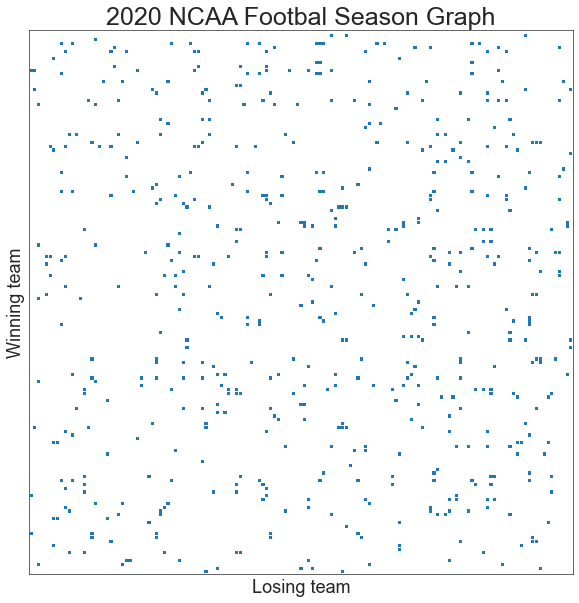

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from graspologic.plot import adjplot
import seaborn as sns

# REF: https://www.sports-reference.com/cfb/years/2020.html
schedule = pd.read_csv("networks-course/data/sports/ncaa_football_2020.csv")


def filt(string):
    return re.sub(r"\([0123456789]*\) ", "", string)


vec_filt = np.vectorize(filt)

schedule["Winner"] = vec_filt(schedule["Winner"])
schedule["Loser"] = vec_filt(schedule["Loser"])


unique_winners = np.unique(schedule["Winner"])
unique_losers = np.unique(schedule["Loser"])
teams = np.union1d(unique_winners, unique_losers)
n_teams = len(teams)

adjacency_df = pd.DataFrame(
    index=teams, columns=teams, data=np.zeros((n_teams, n_teams))
)

for idx, row in schedule.iterrows():
    winner = row["Winner"]
    loser = row["Loser"]
    adjacency_df.loc[winner, loser] += 1

remove_winless = False
n_wins = adjacency_df.sum(axis=1)
if remove_winless:
    teams = teams[n_wins > 0]
    n_wins = adjacency_df.sum(axis=1)
adjacency_df = adjacency_df.reindex(index=teams, columns=teams)

n_teams = len(teams)

sns.set_context("talk")

ax, _ = adjplot(adjacency_df.values, plot_type="scattermap", sizes=(10, 10), marker="s")
ax.set_title("2020 NCAA Footbal Season Graph", fontsize=25)
ax.set(ylabel="Winning team")
ax.set(xlabel="Losing team")

print(f"Number of teams {n_teams}")

In [4]:
import networkx as nx
g = nx.from_pandas_adjacency(adjacency_df, create_using=nx.DiGraph)
g_sym = nx.from_pandas_adjacency(adjacency_df + adjacency_df.T, create_using=nx.Graph)
pos = nx.kamada_kawai_layout(g)

nodelist = adjacency_df.index
node_data = pd.DataFrame(index=nodelist)
node_data

""
Abilene Christian
Air Force
Akron
Alabama
Alabama-Birmingham
...
Western Carolina
Western Kentucky
Western Michigan
Wisconsin


In [ ]:
import networkx as nx
from graspologic.plot import networkplot
from graspologic.partition import leiden

g = nx.from_pandas_adjacency(adjacency_df, create_using=nx.DiGraph)
g_sym = nx.from_pandas_adjacency(adjacency_df + adjacency_df.T, create_using=nx.Graph)
pos = nx.kamada_kawai_layout(g)

nodelist = adjacency_df.index
node_data = pd.DataFrame(index=nodelist)

xs = []
ys = []
for node in adjacency_df:
    xs.append(pos[node][0])
    ys.append(pos[node][1])
xs = np.array(xs)
ys = np.array(ys)

node_data["x"] = xs
node_data["y"] = ys

partition_map = leiden(g_sym, trials=100, random_seed=8888)
labels = np.vectorize(partition_map.get)(nodelist)

node_data["leiden_labels"] = labels

ax = networkplot(
    adjacency_df.values,
    node_data=node_data.reset_index(),  # bug in this function requires the .reset_index
    x="x",
    y="y",
    node_alpha=1.0,
    edge_alpha=1.0,
    edge_linewidth=0.6,
    node_hue="leiden_labels",
    node_kws=dict(s=100, linewidth=2, edgecolor="black"),
    palette="Set1",
)
_ = ax.axis("off")

```{admonition} Question
:class: tip

What do you think the communities I plot above correspond to?
```

In [ ]:
adjacency_df.index[labels == 2].values

## Simple and eigenvector rankings

```{admonition} Question
:class: tip

What is perhaps the simplest way to say which teams are doing well in a given year, say
just given the outcome of each game in a season?

For the metric you just described, how can we compute it using the adjacency matrix?
```

Let $r_0$ be the vector of all ones. Note now that 

$$r = A r_0$$

is calculating the *number of wins* for each team if the adjacency matrix just has 
counts of wins in its elements.

In [ ]:
n_wins = np.sum(adjacency_df, axis=1)
node_data["n_wins"] = n_wins
n_wins.sort_values(ascending=False)

Note that it is easy to have ties in this ranking. Also, teams could play different
numbers of games in some leagues/situations, which we might want to account for. With 
$d_i$ being the total degree of node $i$ (numbers of wins AND losses), and $D$ being 
a matrix with these degrees on the diagonal we could make an adjustment like 

$$r = D^{-1} A r_0$$

$$r = P r_0$$

```{admonition} Question
:class: tip

How can we interpret this new ranking scheme in terms of wins/losses for a given team?
```

In [ ]:
n_games = np.sum(adjacency_df, axis=0) + np.sum(adjacency_df, axis=1)
win_rates = n_wins / n_games
node_data["win_rate"] = win_rates
win_rates.sort_values(ascending=False)

In [ ]:
from scipy.stats import rankdata


def rank_to_order(key):
    node_data[f"{key}_order"] = rankdata(node_data[key])


rank_to_order("win_rate")

In a league like NCAA where not all teams play each other, this ranking does
not account for strength of schedule. Perhaps our ranking scheme should account not just
for the number or proportion of wins, but also the quality of the teams that we beat. We
can account for this by instead, say, calculating the sum of the number of wins of the 
teams that team $i$ beat:

$$r = A A r_0 = A^2 r_0$$

I love this quote from {cite:ts}`keener1993perron` (I have changed the mathematical
notation only to match ours): 
> "I have heard it suggested by a nationally prominent football coach that $A^2 r_0$ should be used to determine a 
national champion... Of course, he did not express his scheme in mathematical notation, 
and, therefore, did not see the obvious generalization of using $A^s r_0$ with large 
$s$."

Earlier in the course, we talked about [power iteration](https://en.wikipedia.org/wiki/Power_iteration). 
This is a method for calculating the principal eigenvector/eigenvalue of a matrix. It is
based on the idea that, as $s$ goes to infinity, 

$$\lim_{s \rightarrow \infty} \frac{A^s r_0}{\|A^s r_0\|} = r$$

where here $r$ is now the principal eigenvector of $A$.


```{note}
Fun fact: this positive principal eigenvector is only guaranteed to exist when the
network is fully (weakly) connected (see the [Perron-Frobenius theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem) 
or {cite:t}`keener1993perron`). But this is kind of cool - if the network weren't 
fully connected, it would mean that we can divide the set of teams into groups that 
never play each other - in other words, they are different leagues! So this breaks down
exactly when we'd expect it to.
```

In [ ]:
A = adjacency_df.values


def eig(A):
    evals, evecs = np.linalg.eig(A)
    sort_inds = np.argsort(-evals)
    evals = evals[sort_inds]
    evecs = evecs[:, sort_inds]
    return evals, evecs


evals, evecs = eig(A)
principal_evec = np.abs(evecs[:, 0])
eigvec_ranking = pd.Series(index=adjacency_df.index, data=principal_evec)
node_data["evec_rank"] = eigvec_ranking
rank_to_order("evec_rank")
eigvec_ranking.sort_values(ascending=False)

In [ ]:
from matplotlib import colors


def plot_network_color_scaled(key):
    levels = list(np.sort(node_data[key].unique()))
    cmap = sns.color_palette("Blues", as_cmap=True)
    vmin = np.min(levels)
    norm = colors.Normalize(vmin=0.3 * vmin)
    palette = dict(zip(levels, cmap(norm(levels))))

    ax = networkplot(
        adjacency_df.values,
        node_data=node_data.reset_index(),  # bug in this function requires the .reset_index
        x="x",
        y="y",
        node_alpha=1.0,
        edge_alpha=1.0,
        edge_linewidth=0.6,
        node_hue=key,
        node_size=key,
        node_sizes=(30, 300),
        node_kws=dict(linewidth=1.5, edgecolor="black"),
        palette=palette,
        edge_kws=dict(color=sns.color_palette()[0]),
    )
    ax.axis("off")
    return ax

In [ ]:
plot_network_color_scaled("evec_rank_order")

### Brief aside

Watch what happens if you use the normalized adjacency / Laplacian here instead.

In [ ]:
k = np.sum(A, axis=0) + np.sum(A, axis=1)
D_inv = np.diag(1 / k)
P = D_inv @ A

evals, evecs = eig(P)
principal_evec_lap = np.abs(evecs[:, 0])
eigvec_ranking_lap = pd.Series(index=adjacency_df.index, data=principal_evec_lap)
node_data["evec_rank_lap"] = eigvec_ranking_lap
rank_to_order("evec_rank_lap")
eigvec_ranking_lap.sort_values(ascending=False)[:10]

In [ ]:
plot_network_color_scaled(key="evec_rank_lap")

## Signal flow / laplacian ranking

There is another, similar but distinct notion of ranking which is related to the network
Laplacian. Let's write down a couple of definitions:

$W \in \mathbb{R}^{n \times n}$: $\frac{A + A^T}{2}$, the symmetrized adjacency matrix

$\Delta \in \mathbb{R}^{n \times n}$: an antisymmetric matrix, which we will specify later

$z \in \mathbb{R}^{n}$: the vector of signal flows for each node $\{1, 2, ... ,n\}$


### Defining an energy (objective) function
We start by defining an energy function:

$$E(z) = \frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i - z_j - \delta_{ij})^2$$

$$E(z) = \frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i - z_j)^2 - \sum_{i, j = 1}^n w_{ij} \delta_{ij} (z_i - z_j) + \frac{1}{2} \sum_{i, j = 1}^n w_{ij} x_{ij}^2$$

Let $E_0 = \frac{1}{2} \sum_{i, j = 1}^n w_{ij} x_{ij}^2$

Note that $\frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i - z_j)^2$ is related to the unnormalized graph laplacian: $L = D - W$

$$\frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i - z_j)^2$$

$$\frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i^2 - 2z_i z_j - z_j^2)$$

Let $d_i = \sum_{j = 1}^n w_{ij}$, the degree of node $i$. Since $W$ is symmetric

$$\frac{1}{2} \sum_{i = 1}^n d_i z_i^2 - \sum_{i, j = 1}^n w_{ij} z_i z_j + \frac{1}{2} \sum_{j = 1}^n d_j z_j^2$$

$$\frac{1}{2} \sum_{i = 1}^n d_i z_i^2 - \sum_{i, j = 1}^n w_{ij} z_i z_j + \frac{1}{2} \sum_{j = 1}^n d_j z_j^2$$

$$\sum_{i = 1}^n d_i z_i^2 - \sum_{i, j = 1}^n w_{ij} z_i z_j$$

$$z^T D z - z^T W z$$

$$z^T (D - W) z$$

$$z^T L z$$

Now, consider the term 

$$\sum_{i, j = 1}^n w_{ij} \delta_{ij} (z_i - z_j)$$

$$\sum_{i, j = 1}^n w_{ij} \delta_{ij} z_i  -  \sum_{i, j = 1}^n w_{ij} \delta_{ij}z_j$$

$$\sum_{i, j = 1}^n w_{ji}( - \delta_{ji}) z_i  -  \sum_{i, j = 1}^n w_{ij} \delta_{ij}z_j$$

$$\sum_{i, j = 1}^n w_{ji}( - \delta_{ji}) z_i  -  \sum_{i, j = 1}^n w_{ij} \delta_{ij}z_j$$

define $b_i = \sum_{j=1}^n w_{ij}x_{ij}$. Now the above reduces to

$$-z^Tb - z^Tb = -2z^Tb$$

$$E(z) = \frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i - z_j)^2 - \sum_{i, j = 1}^n w_{ij} \delta_{ij} (z_i - z_j) + \frac{1}{2} \sum_{i, j = 1}^n w_{ij} x_{ij}^2 = z^T L z - 2z^T b + E_0$$

where $E_0$ is the remaining constant (which does not depend on $z$). 

### Solving for $z$

Taking the derivative of $E(z)$, 

$$\frac{dE(z)}{dz} = \frac{d}{dz} (z^T L z - 2z^T b + E_0) =  2 L z - 2 b$$

Setting equal to 0, 

$$L z = b$$

$L$ is singular. To see this, recall that 

$$Lx = (D - W)x$$

Let $x$ be the vector of all ones, then 

$$(Dx - Wx)_i = d_i - \sum_{j=1}^n w_{ij} = 0$$

Thus, $Lx = 0 = 0x$ so the vector of all ones is an eigenvector of $L$ with eigenvalue $0$, so $L$ is not invertible. 

However, we can solve 

$$\min_z \| Lz - b \|_2 $$

via the Moore-Penrose inverse of $L$, $L^\dagger$.


$$z^* = L^\dagger b$$

The Moore-Penrose inverse yields the _unique_ solution to $\min_z \| Lz - b \|_2$ _with minimum 2-norm_. However, there are many solutions, all of the form 

$$z^* = L^\dagger b + y$$

where $y \in Null(L)$. What is in $Null(L)$? Any vector spanned by the vector of all ones, as shown above! This means that all of the values of the signal flow vector $z$ could be shifted by a constant and the value of the objective function $E(z)$ would remain the same. Signal flow is not an absolute measure, but rather, a measure of where a node lives in the graph relative to its peers. 

### Defining $\Delta$

What we have seen is that 

$$E(z) = \frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i - z_j - \delta_{ij})^2$$

is minimized by $z = L^\dagger b$, where $b$ is a vector such that $b_i = \sum_{j=1}w_{ij}\delta_{ij}$

$\Delta$ can be whatever we choose, as long as it is antisymmetric. One choice used in _Varshney et al. 2011_ is $\delta_{ij} = sgn(A_{ij} - A_{ji})$ This choice makes some intuitive sense. 

### Some intuition
Considering a single pair of nodes, $i, j$, the energy function looks like 

$$ w_{ij} (z_i - z_j - sgn(A_{ij} - A_{ji})) $$

If $A_{ij} > A_{ji}$, then node $i$ projects more strongly to $j$ than $j$ does to it. $sgn(A_{ij} - A_{ji})$ returns 1, and so the optinal configuration of $z_i$ and $z_j$ is to have $z_i = z_j + 1$. 

$z$ is chosen by weighting each of these terms by the average projection weight $w_{ij}$, and finding the solution $z$ which minimizes these terms over all $i, j$ pairs. 

In [ ]:
W = (A + A.T) / 2

D = np.diag(np.sum(W, axis=1))

L = D - W

b = np.sum(W * np.sign(A - A.T), axis=1)
L_dagger = np.linalg.pinv(L)  # this is the Moore-Penrose inverse
z = L_dagger @ b

signal_flow_rank = pd.Series(data=z, index=adjacency_df.index)
node_data["sf_rank"] = signal_flow_rank - signal_flow_rank.min()
rank_to_order("sf_rank")
signal_flow_rank.sort_values(ascending=False)

In [ ]:
plot_network_color_scaled("sf_rank_order")

## Upset minimization or minimum violations ranking

Now, let's switch gears entirely, and talk about a completely different perspective on 
the ranking problem. I'll start by making a very simple claim: a good ranking of my
teams is one in which, as often as is possible, the higher ranked team beat the lower
ranked one. 

```{admonition} Question
:class:tip

If we are just interested in an *ordering* of the teams, and not necessarily a 
score/number associated with each, then how can we represent this ordering of the teams
mathematically using the tools from this course?
```

How can we write what we are after mathematically? If $P$ is a permutation matrix, then 
we can write:

$$\min_P \sum_{i<j}^n (P A P^T)_{ij}$$

In other words, this is the sum of the upper triangular elements of some permuted
version of the adjacency matrix. 

```{admonition} Question
:class: tip

Let's say we trust this ordering of the teams under some $P$. What does the sum of the
upper triangle represent? The sum of the lower triangle?
```

```{admonition} Question
:class: tip

Can you think of a way to formulate the optimization problem above, using the tools
that we talked about in this course?
```

In [ ]:
from graspologic.match import GraphMatch

adj = adjacency_df.values

# constructing the match matrix
match_mat = np.zeros_like(adj)
triu_inds = np.triu_indices(len(match_mat), k=1)
match_mat[triu_inds] = 1

# running graph matching
np.random.seed(8888)
gm = GraphMatch(n_init=200, max_iter=150, eps=1e-6, n_jobs=-2)
gm.fit(match_mat, adj)
gm_perm_inds = gm.perm_inds_

In [ ]:
adj_matched = adj[gm_perm_inds][:, gm_perm_inds]
upsets = adj_matched[triu_inds[::-1]].sum()
n_games = adj_matched.sum()

gm_ranking_teams = teams[gm_perm_inds]

gm_rank_order = pd.Series(
    index=gm_ranking_teams,
    data=len(teams) + 1 - np.arange(1, len(teams) + 1, dtype=int),
)
node_data["gm_rank_order"] = gm_rank_order

print(f"Number of games: {n_games}")
print(f"Number of non-upsets (graph matching score): {gm.score_}")
print(f"Number of upsets: {upsets}")
print(f"Upset ratio: {upsets/n_games}")

gm_rank_order.sort_values(ascending=False)

In [ ]:
def plot_sorted_adjacency(
    adj,
    shade_upsets=True,
    ax=None,
    perm_inds=None,
    label=False,
    plot_type="scattermap",
    title="",
):
    if perm_inds is not None:
        adj = adj[perm_inds][:, perm_inds]
    if plot_type == "scattermap":
        ax, _ = adjplot(adj, plot_type="scattermap", sizes=(10, 10), marker="s", ax=ax)
    else:
        ax, _ = adjplot(adj, plot_type="heatmap", ax=ax)

    triu_inds = np.triu_indices(len(match_mat), k=1)
    n_upsets = adj[triu_inds[::-1]].sum()
    n_games = adj.sum()
    p_upset = n_upsets / n_games

    ax.set_title(title)

    ax.plot([0, n_teams], [0, n_teams], linewidth=1, color="black", linestyle="-")
    if label:
        ylabel = r"$\leftarrow$ Ranked low         "
        ylabel += "Winning team           "
        ylabel += r"Ranked high $\rightarrow$"
        ax.set_ylabel(ylabel, fontsize="large")
        ax.set(xlabel="Losing team")
    # ax.set_title("2020 NCAA Footbal Season Graph", fontsize=25)
    if shade_upsets:
        ax.fill_between(
            [0, n_teams],
            [0, n_teams],
            [n_teams, n_teams],
            zorder=-1,
            alpha=0.4,
            color="lightgrey",
        )
        ax.text(n_teams / 4, 3 / 4 * n_teams, f"Upsets: {p_upset:0.2f}")

    return ax


plot_sorted_adjacency(adj, perm_inds=gm_perm_inds)

In [ ]:
plot_network_color_scaled("gm_rank_order")

```{admonition} Question
:class: tip

Graph matching requires an initialization. This could be an initial permutation. What
would a good choice of initialization be?
```

## Compare these ranking schemes

In [ ]:
wr_perm_inds = np.argsort(-win_rates)

evec_perm_inds = np.argsort(-principal_evec)

sf_perm_inds = np.argsort(-z)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plot_sorted_adjacency(adj, perm_inds=wr_perm_inds, ax=axs[0], title="Win rate")
plot_sorted_adjacency(adj, perm_inds=evec_perm_inds, ax=axs[1], title="Eigenvector")
plot_sorted_adjacency(adj, perm_inds=sf_perm_inds, ax=axs[2], title="Signal flow")
plot_sorted_adjacency(
    adj, perm_inds=gm_perm_inds, ax=axs[3], title="Upset minimization"
)
plt.tight_layout()

## Ranking soccer teams

In [ ]:
from pathlib import Path

league = "LALIGA1"
data_dir = Path("./networks-course/data/sports/soccer")
start_year = 0
seasons = []
for year in range(start_year, 21):
    filename = f"{league}_{year}_{year+1}.csv"
    season_df = pd.read_csv(
        data_dir / filename, engine="python", usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8]
    )
    season_df["season"] = f"{year}/{year+1}"
    seasons.append(season_df)
games = pd.concat(seasons, ignore_index=True)

edges = []
games["source"] = "none"
games["target"] = "none"
for idx, row in games.iterrows():
    if row["FTHG"] > row["FTAG"]:
        source = row["HomeTeam"]
        target = row["AwayTeam"]
        weight = 1
    elif row["FTHG"] < row["FTAG"]:
        target = row["HomeTeam"]
        source = row["AwayTeam"]
        weight = 1
    else:
        target = row["HomeTeam"]
        source = row["AwayTeam"]
        weight = 1 / 2
        edges.append(
            {
                "source": source,
                "target": target,
                "season": row["season"],
                "weight": weight,
            }
        )
        source = row["HomeTeam"]
        target = row["AwayTeam"]
        weight = 1 / 2
    # ignore ties for now
    edges.append(
        {"source": source, "target": target, "season": row["season"], "weight": weight}
    )
edgelist = pd.DataFrame(edges)

nodelist = list(edgelist["source"].unique()) + list(edgelist["target"].unique())
nodelist = np.unique(nodelist)

In [ ]:
from graspologic.utils import remove_loops


def signal_flow(A):
    """Implementation of the signal flow metric from Varshney et al 2011

    Parameters
    ----------
    A : [type]
        [description]

    Returns
    -------
    [type]
        [description]
    """
    A = A.copy()
    A = remove_loops(A)
    W = (A + A.T) / 2

    D = np.diag(np.sum(W, axis=1))

    L = D - W

    b = np.sum(W * np.sign(A - A.T), axis=1)
    L_pinv = np.linalg.pinv(L)
    z = L_pinv @ b

    return z


def rank_signal_flow(A):
    sf = signal_flow(A)
    perm_inds = np.argsort(-sf)
    return perm_inds


def rank_graph_match_flow(A, n_init=100, max_iter=50, eps=1e-5, **kwargs):
    n = len(A)
    initial_perm = rank_signal_flow(A)
    init = np.eye(n)[initial_perm]
    match_mat = np.zeros((n, n))
    triu_inds = np.triu_indices(n, k=1)
    match_mat[triu_inds] = 1
    gm = GraphMatch(
        n_init=n_init, max_iter=max_iter, init="barycenter", eps=eps, **kwargs
    )
    perm_inds = gm.fit_predict(match_mat, A)
    return perm_inds


def calculate_p_upper(A):
    A = remove_loops(A)
    n = len(A)
    triu_inds = np.triu_indices(n, k=1)
    upper_triu_sum = A[triu_inds].sum()
    total_sum = A.sum()
    upper_triu_p = upper_triu_sum / total_sum
    return upper_triu_p

In [ ]:
rankings = []
ranking_stats = []
for season, season_edges in edgelist.groupby("season", sort=False):
    g = nx.from_pandas_edgelist(
        season_edges, edge_attr="weight", create_using=nx.MultiDiGraph
    )
    season_nodes = np.intersect1d(nodelist, g.nodes)
    adj = nx.to_numpy_array(g, nodelist=season_nodes)
    perm_inds = rank_graph_match_flow(adj, n_init=50)
    p_upper = calculate_p_upper(adj[np.ix_(perm_inds, perm_inds)])
    rankings.append(
        pd.Series(
            data=np.arange(len(season_nodes)),
            name=season,
            index=season_nodes[perm_inds],
        )
    )
    ranking_stats.append(
        {
            "p_upper": p_upper,
            "season": season,
            "season_start": int(season.split("/")[0]),
        }
    )
ranking_stats = pd.DataFrame(ranking_stats)
rankings = pd.DataFrame(rankings).T
rankings.index.name = "team"
rankings["mean"] = rankings.fillna(30).mean(axis=1)
rankings = rankings.sort_values("mean")

In [ ]:
times_not_in_league = rankings.isna().sum(axis=1)
common_teams = rankings.index[times_not_in_league < 5]

In [ ]:
import colorcet as cc

plot_rankings = rankings.fillna(30).reset_index().drop("mean", axis=1)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
pd.plotting.parallel_coordinates(
    plot_rankings,
    class_column="team",
    ax=ax,
    color=cc.glasbey_light,
)
ax.get_legend().remove()
ax.set(ylim=(21, -1))
ax.legend(bbox_to_anchor=(1, 1), loc="upper left", ncol=2, title="Team")
ticks = np.array([1, 5, 10, 15, 20])
ax.set(yticks=ticks - 1, yticklabels=ticks)
ax.set_title("La Liga", fontsize="xx-large")
ax.set_xlabel("Season", fontsize="x-large")
ax.set_ylabel("Ranking", fontsize="x-large")

# plot only the teams that are usually in la liga
plot_rankings = plot_rankings[plot_rankings["team"].isin(common_teams)]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
pd.plotting.parallel_coordinates(
    plot_rankings,
    class_column="team",
    ax=ax,
    color=cc.glasbey_light,
)
ax.get_legend().remove()
ax.set(ylim=(21, -1))
ax.legend(bbox_to_anchor=(1, 1), loc="upper left", ncol=2, title="Team")
ticks = np.array([1, 5, 10, 15, 20])
ax.set(yticks=ticks - 1, yticklabels=ticks)
ax.set_title("La Liga (common teams only)", fontsize="xx-large")
ax.set_xlabel("Season", fontsize="x-large")
ax.set_ylabel("Ranking", fontsize="x-large")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.lineplot(data=ranking_stats, x="season_start", y="p_upper")
ticks = [0, 5, 10, 15, 20]
_ = ax.set(
    xticks=ticks,
    xticklabels=ticks,
    xlabel="Season start year",
    ylabel="Non-upset proportion",
)
ax.spines[["top", "right"]].set_visible(False)

## Other applications

```{figure} ./slide_images/fac-network-sorted.png

Ranking of a network of faculty hires in computer science. Figure from {cite:t}`clauset2015systematic`.
```

```{figure} ./slide_images/ranking-neuro.png
---
width: 300px
---

Ordering the predominant direction of flow in a network of neurons, and comparing between
edge types. Figure by Michael Winding.
```

## References 
```{bibliography}
:filter: docname in docnames
:style: unsrt
```